## 社群媒體分析期末專案：Mobile01汽車改裝話題之輿論分析 <br>

<b>組別 : 第八組 <br>
<br>
組員 : M134020024 盧萩原 / M134020032 姚柏豐 / M134020046 宋旻家 <br>
<br>
YouTube影片連結 : https://youtu.be/yE9ZLjBXvtE
</b>

In [ ]:
#連接雲端資料夾
import os
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


###  A. 動機與分析目的
- <b>研究動機</b> : <br>
隨著網路社群平台的蓬勃發展，愈來愈多消費者在進行商品選購或使用時，會於論壇分享經驗、交流意見，這些大量的用戶產出內容已成為反映市場趨勢與消費行為的重要資料來源。<br>
其中，Mobile01作為台灣最大3C與汽車相關討論社群，其汽車版更聚集了大量對汽車性能與外觀等提升有興趣的改裝用戶。透過探討此類論壇中「改裝」相關討論，可深入了解台灣車主在汽車改裝上的偏好、關注焦點與情緒態度等等潛在的資訊。<br>

- <b>研究目的</b> : <br>
本研究針對Mobile01汽車板中與「改裝」相關的文章進行分析。<br>
研究透過自然語言處理技術與情緒分析等等文字探勘方法，分析論壇用戶在改裝主題上的常見關鍵字、情緒表現與語意特徵，進一步掌握討論焦點與用戶偏好。<br>
此外，我們也運用主題模型對文章內容進行分群與主題分類，觀察不同主題類型的討論趨勢。最終希望透過這些分析，探討網路論壇中汽車改裝相關討論來更深入了解在汽車產業上對於各廠牌、產品的滿意度、關注度等等相關的潛在訊息，以期望能夠發現更多潛在消費者。<br>

### B. 資料集描述
<b>資料來源 : </b>
- 使用Tarflow工作流程平台之爬蟲流程，蒐集 Mobile01 汽車板之文章
- 關鍵字：「改裝」
- 時間：2022-01-01 ~ 2025-5-20
- 資料筆數：共 906 篇文章
- 資料欄位數 : 6

### C/D. 資料分析與解釋
大綱 :
1. 資料前處理 <br>
    - 1.1 資料清理 <br>
    - 1.2 文章斷詞與整理 <br>
    - 1.3 斷詞後之文字雲 <br>
2. Lexicon-based 情緒分析 <br>
    - 2.1 正負向情緒詞彙頻率折線圖 <br>
    - 2.2 篩選出正向最高峰時段以驗證情緒事實 <br>
3. BERT sentiment classification <br>
    - 3.1 用BERT給每個句子情緒分數 <br>
    - 3.2 情緒分數分佈盒狀圖 <br>
    - 3.3 正負面情緒詞頻前10高的長條圖 <br>
    - 3.4 正負面情緒詞之文字雲 <br>
4. 使用LLM Information Extraction進行情緒分析 <br>
    - 4.1 啟動 Ollama <br>
    - 4.2 定義 LLM 輸出格式 <br>
5. LDA主題模型 <br>
    - 5.1 LDA 主題模型 <br>
    - 5.2 查看 LDA 主題代表字 <br>
    - 5.3 透過指標找出最佳主題數 <br>
    - 5.4 視覺化呈現 <br>
    - 5.5 主題分佈應用，搭配其他文章資訊 <br>
<br>
6. BERT Text Clustering <br>
    - 6.1 使用 BERTopic 建立主題模型 <br>
    - 6.2 查看各主題的詞彙分佈 <br>
    - 6.3 採用KeyBERT做主題分類 <br>
7. 詞彙關係圖 <br>
<br>
8. 社群網路分析 <br>
    - 8.1 發文者與留言者關係 <br>
    - 8.2 網友之間的關係 <br>
    - 8.3 Measure on Graph <br>

### 0. 套件安裝、圖表、字體設定

In [1]:
# 套件
import pandas as pd
import jieba
import jieba.analyse
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import multiprocessing
import matplotlib.pyplot as plt

In [2]:
from matplotlib import font_manager
%matplotlib inline

# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體
# 指定使用的中文字體
# # plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # Windows 中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode Ms'] # MacOS 內建中文字體

# 設定文字雲中文字體路徑
fontPath = './TaipeiSansTCBeta-Regular.ttf' # 設定字型
fprop = font_manager.FontProperties(fname=fontPath)  # 載入字型


# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

### 1. 資料前處理

讀取 mobile01 檔案: mobile01_car.csv

In [3]:
# 匯入資料
df = pd.read_csv('./raw_data/mobile01_car.csv')
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date

df.head(3)

,system_id,dataSource,artUrl,artDate,artTitle,artContent,commentCount
0,1,Mobile01,https://www.mobile01.com/topicdetail.php?f=264...,2022-12-04,"7代 Camry hybrid JBL音響,前門板共振聲請益",近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...,4
1,2,Mobile01,https://www.mobile01.com/topicdetail.php?f=260...,2022-12-05,真圓有問題🤨,各位大神大家好小弟的車系是Focus 16吋的前幾日去桃園某店家換輪胎 然後店家有做平衡告知...,8
2,3,Mobile01,https://www.mobile01.com/topicdetail.php?f=262...,2022-12-05,中華菱利 A180 露營車試駕體驗｜可合法上路的純國產掀頂露營車！,這幾年露營活動愈來愈盛行，可說帶動了不少相關產業與產品的發展，露營車便是其中之一；而這輛精巧...,176


1.1 資料清理

In [4]:
# 去除一些不需要的欄位
metaData = df.drop(['commentCount','dataSource'], axis=1)

#去除文章內容為空值的筆數
metaData.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

metaData['sentence'] = metaData['artContent'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}") # 斷句
metaData = metaData.explode('sentence').reset_index(drop=True)

# 刪除清洗後為空的row
metaData = metaData[metaData['sentence'] != '']

metaData.head(3)

,system_id,artUrl,artDate,artTitle,artContent,sentence
0,1,https://www.mobile01.com/topicdetail.php?f=264...,2022-12-04,"7代 Camry hybrid JBL音響,前門板共振聲請益",近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...,近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...
1,1,https://www.mobile01.com/topicdetail.php?f=264...,2022-12-04,"7代 Camry hybrid JBL音響,前門板共振聲請益",近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...,前座的兩側門板就會傳來非常明顯的共振聲響
2,1,https://www.mobile01.com/topicdetail.php?f=264...,2022-12-04,"7代 Camry hybrid JBL音響,前門板共振聲請益",近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...,等化器高中低音都調整為中值還是會產生這樣的共振. 請見下列左右側門板的影片想請教各位這是喇叭...


1.2 文章斷詞與整理

In [5]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 加入自定義詞彙
custom_words = [
    "行車紀錄器","導航主機","盲點偵測","倒車雷達","數位儀表","電動尾門","LED頭燈",
    "改很大","爆改","求推薦", "渦輪增壓","自然進氣","渦輪車","進氣系統","排氣管","避震器",
    "底盤強化","平衡桿","拉桿","鋁圈","卡鉗","煞車皮","碟盤","進氣壩","尾翼","空力套件","大包",
    "爆龜","燻黑尾燈","車貼","改色膜","燈眉","日行燈","有待修","無待修","有無待修","待修","里程數萬公里",
    "Brembo", "TEIN", "HKS", "Cusco", "Recaro", "Bride", "OZ Racing", "APEXi", "Tomei", "K&N",
    "Bilstein", "Greddy", "Eibach","JBL音響"]

for word in custom_words:
    jieba.add_word(word)

# 新增 stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 新增自定義停用字
other_stopwords = [
    "我們", "大家", "目前", "今天", "昨天",
    "車主", "網友", "小弟", "原PO", "感謝", "拜託", "請教", "謝謝", "如題",
    "補充", "更新", "附圖", "小改", "大改", "改一點", "升級一下", "建議", "回覆", "留言",
    "連結","內容","這是","希望","選擇","當初","真的","東西","改裝","改裝車","原廠","全車",
    "算是","一台","照片","請問","有無","只能","看過","那種","這種","這台","車子","感覺","原本",
    "我會","一堆","台灣","汽車","近期","入手","備有","車型","車輛","發現","提供","這輛","則是",
    "也屬","一輛","一模一樣"
    ]

stopWords += other_stopwords

Building prefix dict from /Users/paulyao/Desktop/nsysu/碩一下/SMA/SMA_2025S/final_project/dict/dict.txt.big ...
Loading model from cache /var/folders/8z/rfyy41kd2kdb5ktjc9ztld_00000gn/T/jieba.u2d5cdb311a2d65d0c7c479b91161cce9.cache
Loading model cost 0.407 seconds.
Prefix dict has been built successfully.


In [6]:
# 設定斷詞 function
def getToken(row):
    # 進行斷詞
    seg_list = jieba.lcut(row)
    # 篩選掉停用字與字元數小於 1 的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    return seg_list

In [7]:
data = metaData.copy()

# 斷詞、去除停用字
data['word'] = data.sentence.apply(getToken)

# 將 word 欄位展開
data = data.explode('word').reset_index(drop=True)

# 刪除word欄位為NaN的row
data = data.dropna(subset=['word'])

# 將英文詞轉換為小寫
data['word'] = data['word'].apply(lambda w: w.lower() if isinstance(w, str) else w)

data.head()
bidata=data.copy()

1.3 使用文字雲，視覺化呈現斷詞後的結果

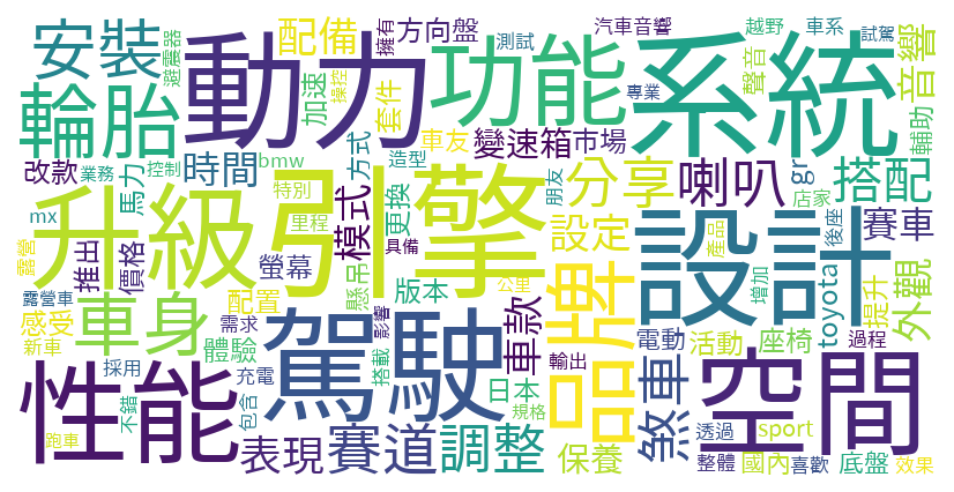

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 統計每個詞出現的次數
word_freq = data['word'].value_counts().to_dict()

# 產生文字雲 (詞頻前100)
wc = WordCloud(font_path=fontPath,  # 指定中文字型路徑
               width=800, height=400,
               background_color='white',
               max_words=100)

wc.generate_from_frequencies(word_freq)

# 顯示文字雲
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

1. 文字雲顯示出汽車改裝文章中，網友最關注的核心主題為「駕駛體驗」、「性能設定」與「動力升級」，相關詞彙如「駕駛」、「操控」、「聲音」、「動力」、「系統」、「設定」等出現頻繁。<br>
2. 除了性能相關改裝外，內裝功能如「音響」、「座椅」、「空間」亦為重要討論項目，顯示使用者對日常體驗與舒適性的關注。<br>
3. 同時，「品牌」、「分享」、「車友」等詞的出現，也反映出社群互動與改裝推薦的文化氛圍。<br>
4. 整體呈現的是一種偏正向、理性的討論。

### 2. Lexicon-based 情緒分析 <br>
使用情緒字典做情緒分析


In [12]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head(3)

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect


情緒字典與斷詞結果進行合併

In [13]:
ptt_liwc_df = pd.merge(data[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df.head(3)

,artUrl,artDate,artTitle,artContent,word,sentiments
0,https://www.mobile01.com/topicdetail.php?f=264...,2022-12-04,"7代 Camry hybrid JBL音響,前門板共振聲請益",近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...,camry,NaN
1,https://www.mobile01.com/topicdetail.php?f=264...,2022-12-04,"7代 Camry hybrid JBL音響,前門板共振聲請益",近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...,hybrid,NaN
2,https://www.mobile01.com/topicdetail.php?f=264...,2022-12-04,"7代 Camry hybrid JBL音響,前門板共振聲請益",近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...,q版,NaN


2.1 正負向情緒詞彙頻率折線圖

In [14]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative")
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
1,2022-01-02,negative,2
2,2022-01-02,positive,17
6,2022-01-05,negative,21
7,2022-01-05,positive,31
11,2022-01-07,negative,3
...,...,...,...
2253,2025-04-30,positive,27
2257,2025-05-01,negative,8
2258,2025-05-01,positive,19
2263,2025-05-02,negative,22


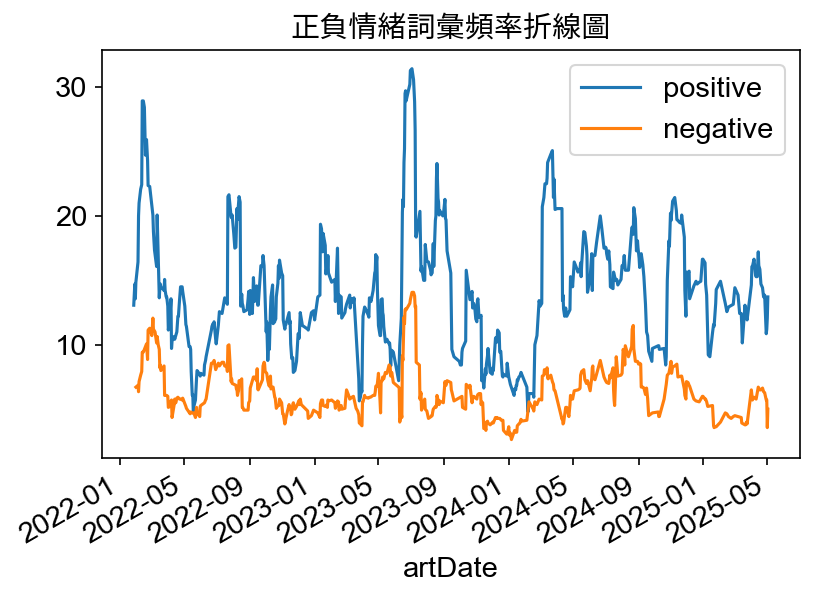

In [15]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)
plt.show()

汽車改裝文章中正面情緒整體明顯高於負面情緒，顯示網友多以分享經驗與推廣產品為主。<br>
不過圖中仍出現數次負面情緒升高的時間點，可能與改裝爭議、法規限制或消費糾紛有關。<br>
而正向高峰可能常出現在車展、新品上市或優惠活動期間，反映社群對改裝話題的熱情與波動性。

2.2 篩選出正向最高峰時段(2023-05~2023-09)以驗證情緒事實

(-0.5, 1599.5, 799.5, -0.5)

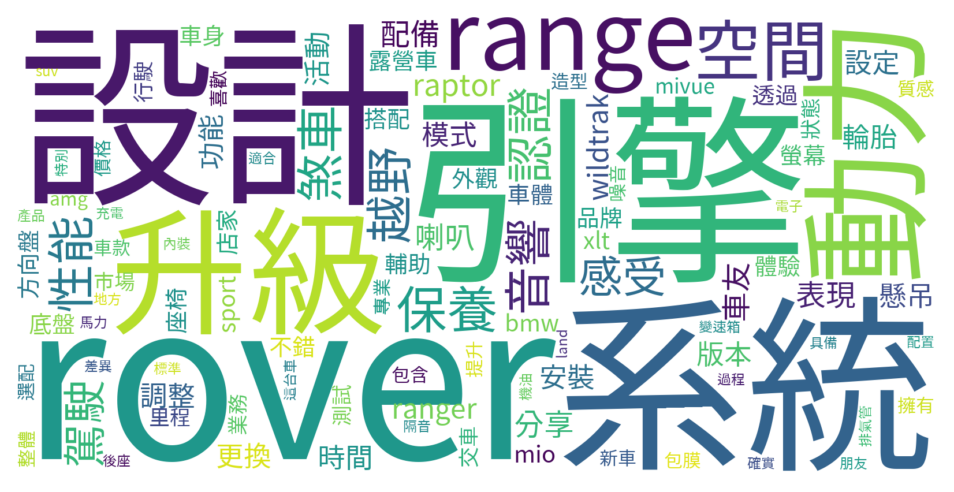

In [16]:
# 將 artDate 轉換為 datetime 格式
data['artDate'] = pd.to_datetime(data['artDate'])

# 篩選出 2023-05 到 2023-09 之間的資料
date = "2023-05-01"
end_date = "2023-09-30"
mask = (data['artDate'] >= date) & (
    data['artDate'] <= end_date) # 時間區間

ptt_df_wc = data.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
cloud = WordCloud(scale = 4, max_words=100, background_color="white", font_path=fontPath)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud,
    interpolation="bilinear"
)
plt.axis("off")

發現大家對於某特定車款有比較正向的熱烈討論。<br>
1. 2023年式的 Ford Ranger Wildtrak 為主角，搭配「升級」、「改裝」、「系統」、「保養」等詞，顯示討論不只是新車，也包括性能強化、使用回饋與改裝經驗。<br>
2. 功能性詞彙如：「動力」、「系統」、「升級」、「配備」、「懸吊」、「越野」、「xlt」、「四驅」。舒適性詞彙如：「空間」、「音響」、「座椅」、「表現」、「內裝」。顯示 Wildtrak 的定位與受眾需求落在「實用越野性能 + 高規內裝」上，許多車主關心它的整體「使用體驗」。
3. 詞彙如：「升級」、「調整」、「功能」、「搭配」、「包膜」、「認證」、「改裝」、「分享」、「表現」、「mivue（行車記錄器品牌）」等，說明該段期間不只是純開箱文，還包含：改裝經驗分享、零件安裝與比較、使用心得與性能回饋等文章。
4. 出現「認證」、「車友」、「分享」、「體驗」詞彙，表示這些文章多數來自實際使用者或車主，社群參與感高，文章較有參考價值。

### 3. BERT sentiment classification

使用 Huggingface 上面已經針對 Sentiment classification 任務 finetune 的 BERT 模型來實作<br>
使用的模型：https://huggingface.co/techthiyanes/chinese_sentiment<br><br>
情緒(start 1到star 5)：<br>
1. Semi-negation<br>
2. Negation<br>
3. Neutral<br>
4. Semi-positive<br>
5. Positive

載入套件

In [ ]:
# !pip install sentence_transformers
# !pip install ckip_transformers

In [17]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker

3.1 用BERT給每個句子情緒分數

In [19]:
# 載入已經被 fine-tune 過的 BERT 模型
model_name = "techthiyanes/chinese_sentiment"
model = pipeline('sentiment-analysis', model=model_name, device="mps")

# 使用模型來進行情緒分析，
text = ["CX-30的變速箱平順開有CVT的感覺,高速與加速都蠻好,配上人馬一體的引擎聲，比較像在開車",
        "原廠炸出200P馬力加上改裝門檻低，那時候到處都是400+的馬力怪獸，常常車子還沒到聲音已經先到"]
result = model(text)

# 輸出結果(標籤和分數)
result

Device set to use mps


[{'label': 'star 5', 'score': 0.7984122633934021},
 {'label': 'star 5', 'score': 0.5509571433067322}]

套用到資料集

In [20]:
# 載入已經被 fine-tune 過的 BERT 模型
model_name = "techthiyanes/chinese_sentiment"
model = pipeline('sentiment-analysis', model=model_name)

# 篩選包含「改裝」的句子（不區分大小寫）
filtered_sentences = metaData[metaData['sentence'].str.contains('改裝', na=False)]

# 建立結果 DataFrame
results_df = pd.DataFrame()
results_df['sentence'] = filtered_sentences['sentence']

# 定義一個函數來進行情緒分析
def analyze_sentiment(sentence):
    try:
        if pd.notna(sentence) and sentence.strip():  # 檢查句子是否為非空
            result = model(sentence)  # 使用 pipeline 進行情緒分析
            label = result[0]['label']
            score = result[0]['score']
            return pd.Series([label, score], index=['label', 'score'])
        else:
            return pd.Series([None, None], index=['label', 'score'])  # 空句子返回空值
    except Exception as e:
        return pd.Series([f"Error: {str(e)}", 0], index=['label', 'score'])

# 使用 apply 函數來進行情緒分析
results_df[['label', 'score']] = results_df['sentence'].apply(analyze_sentiment)

# 輸出結果
results_df.head(10)

Device set to use mps:0


,sentence,label,score
3,這台車況皆為原廠沒有進行任何改裝,star 1,0.367155
5,各位大神大家好小弟的車系是Focus 16吋的前幾日去桃園某店家換輪胎 然後店家有做平衡告知...,star 3,0.349228
22,由於國內並無相關的露營車改裝法規,star 4,0.520588
23,之前玩家們改裝的廂式自走露營車絕大部分都是遊走於法規中的灰色地帶,star 3,0.345694
52,而後交由阡陽負責改裝、送安全審驗,star 4,0.354870
57,一輛已領牌的車就算改成一模一樣也屬違法改裝,star 1,0.691260
94,有人會擔心這樣改裝車高變更後驗車會不會有問題,star 3,0.361045
144,前駕駛艙維持出廠時的模樣未經任何改裝,star 3,0.346019
312,有改裝或鈑金也能免費補鍍,star 4,0.344778
332,但這台可能就是要改裝一下避震跟加強隔音,star 4,0.496872


對情緒分析後的句子進行進一步的探索

In [21]:
# 查看情緒的分布
score_description = results_df['score'].describe()

score_description

count    2042.000000
mean        0.459944
std         0.132470
min         0.000000
25%         0.360501
50%         0.439398
75%         0.550209
max         0.982032
Name: score, dtype: float64

3.2 情緒分數分佈盒狀圖

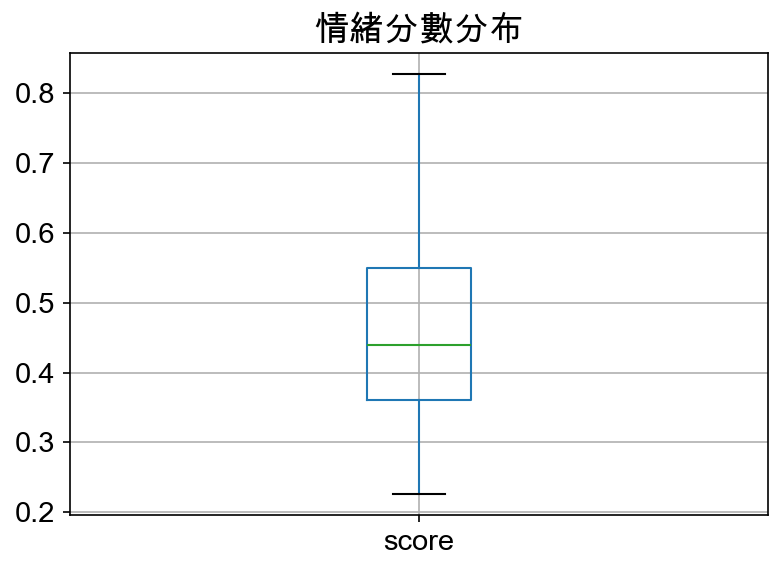

In [22]:
import matplotlib.pyplot as plt

# 情緒分佈盒狀圖
results_df.boxplot(column=['score'], showfliers=False)
plt.title("情緒分數分布")
plt.show()

盒狀圖顯示，情緒分數大多集中在中性至微弱正向之間，整體分數中間偏低，情緒不明顯（信心程度中間略低）。

3.3 正負面情緒詞頻前10高的長條圖

In [23]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 加入自定義詞彙
custom_words = [
    "行車紀錄器","導航主機","盲點偵測","倒車雷達","數位儀表","電動尾門","LED頭燈",
    "改很大","爆改","求推薦", "渦輪增壓","自然進氣","渦輪車","進氣系統","排氣管","避震器",
    "底盤強化","平衡桿","拉桿","鋁圈","卡鉗","煞車皮","碟盤","進氣壩","尾翼","空力套件","大包",
    "爆龜","燻黑尾燈","車貼","改色膜","燈眉","日行燈","有待修","無待修","有無待修","待修","里程數萬公里",
    "Brembo", "TEIN", "HKS", "Cusco", "Recaro", "Bride", "OZ Racing", "APEXi", "Tomei", "K&N",
    "Bilstein", "Greddy", "Eibach","JBL音響","吉普賽之聲"]

for word in custom_words:
    jieba.add_word(word)

# 新增 stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

# 新增自定義停用字
other_stopwords = [
    "我們", "大家", "目前", "今天", "昨天",
    "車主", "網友", "小弟", "原PO", "感謝", "拜託", "請教", "謝謝", "如題",
    "補充", "更新", "附圖", "小改", "大改", "改一點", "升級一下", "建議", "回覆", "留言",
    "連結","內容","這是","希望","選擇","當初","真的","東西","改裝","改裝車","原廠","全車",
    "算是","一台","照片","請問","有無","只能","看過","那種","這種","這台","車子","感覺","原本",
    "我會","一堆","台灣","汽車","近期","入手","備有","車型","車輛","發現","提供","這輛","則是",
    "也屬","一輛","一模一樣","18","有沒有","升級"
    ]

stopWords += other_stopwords


# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'


Building prefix dict from /Users/paulyao/Desktop/nsysu/碩一下/SMA/SMA_2025S/final_project/dict/dict.txt.big ...
Loading model from cache /var/folders/8z/rfyy41kd2kdb5ktjc9ztld_00000gn/T/jieba.u2d5cdb311a2d65d0c7c479b91161cce9.cache
Loading model cost 0.489 seconds.
Prefix dict has been built successfully.


In [24]:
# 繪製長條圖function
def show_barh(words, title=None):
    # 計算詞頻
    word_counts = Counter(words)

    # 輸出最常見的10個詞
    most_common_words = word_counts.most_common(10)

    # 取得詞與對應頻率
    words, counts = zip(*most_common_words)

    # 反轉順序，讓 barh 從上到下是高 → 低
    words = words[::-1]
    counts = counts[::-1]

    # 畫圖
    plt.figure(figsize=(10, 6))
    plt.barh(words, counts)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

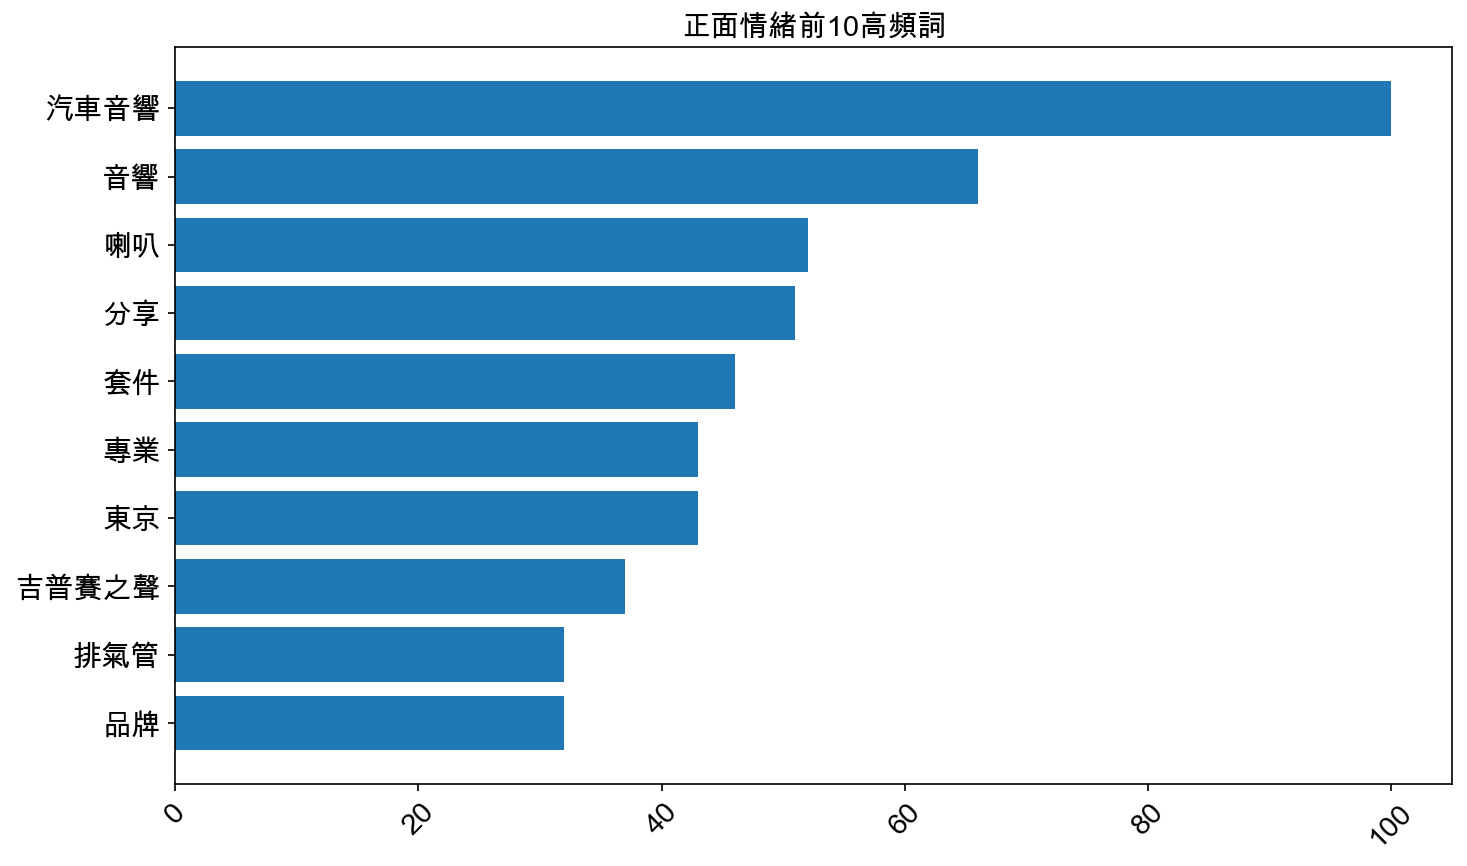

In [25]:
# 篩選出正面情緒的句子（'star 5'）
positive_sentences = results_df[
(results_df['label'].isin(['star 5', 'star 4']))
]['sentence']

# 用jieba進行分詞，並篩選出大於1個字的詞
pos_words = [word for sentence in positive_sentences for word in jieba.lcut(sentence) if len(word) > 1 and word not in stopWords]

show_barh(pos_words, '正面情緒前10高頻詞')

從正面情緒詞彙前十名可以看出，汽車音響類產品（如音響、喇叭）最能激發正向反應，是改裝社群中最受歡迎的升級項目。<br>
此外，「分享」、「套件」、「專業」等詞的高頻出現，也顯示網友傾向於分享改裝成果與推薦產品與店家。<br>
品牌詞有「吉普賽之聲」則反映出品牌形象在正向情緒中的重要性。<br>
整體而言，正面情緒詞彙呈現出以體驗分享、品牌認同與影音升級為核心的語境。

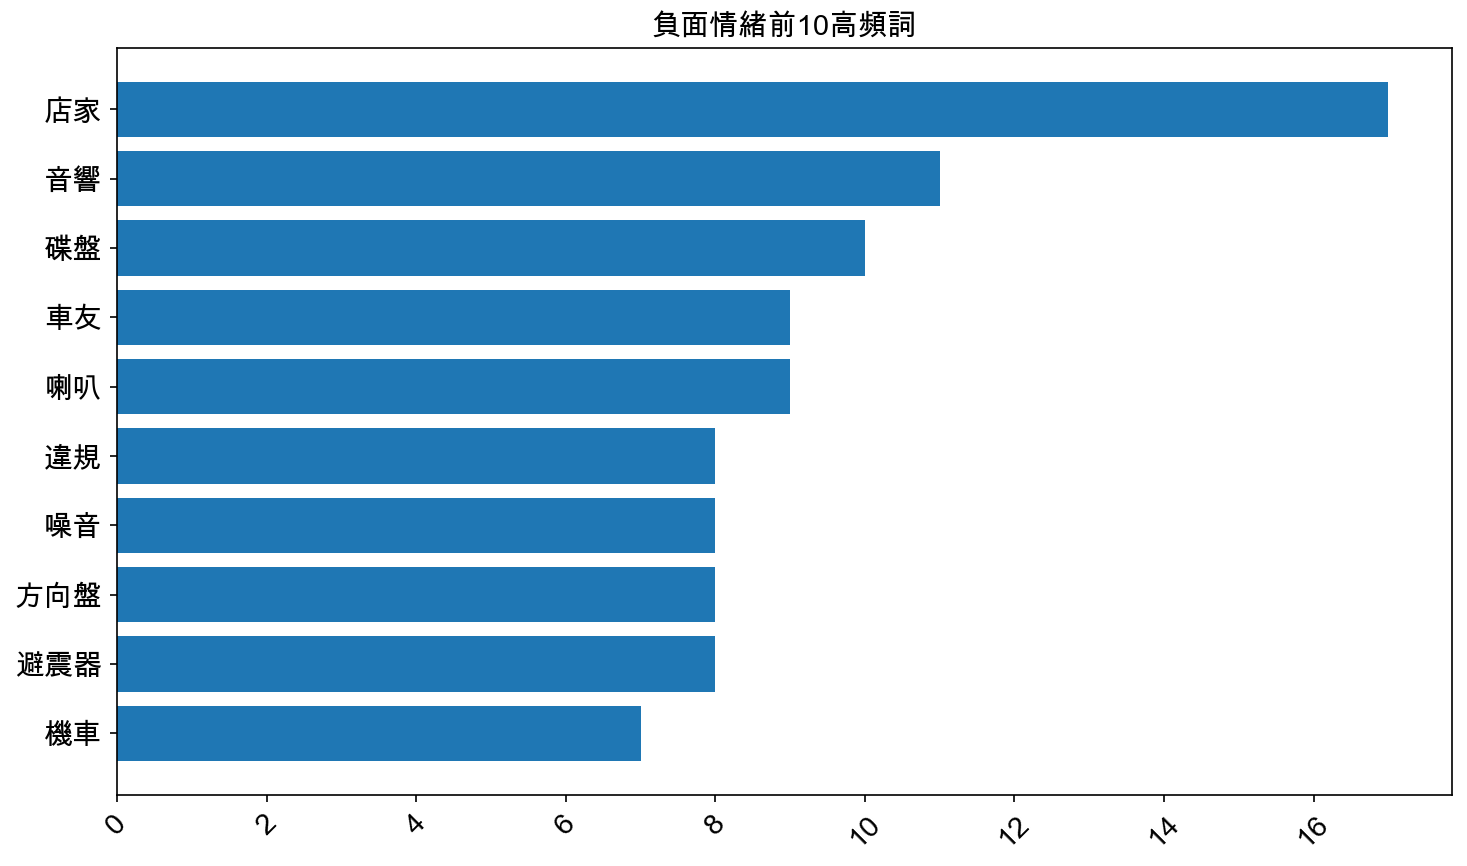

In [26]:
# 篩選出負面情緒的句子（'star 2'）
negative_sentences = results_df[
    (results_df['label'].isin(['star 2', 'star 1']))
]['sentence']

# 用jieba進行分詞，並篩選出大於1個字的詞
neg_words = [word for sentence in negative_sentences for word in jieba.lcut(sentence) if len(word) > 1 and word not in stopWords]

show_barh(neg_words, '負面情緒前10高頻詞')

在負面情緒的前十名詞彙中，最常出現的詞彙是「店家」，顯示消費者對於改裝服務提供者的不信任或不滿為主要負面來源。<br>
音響相關詞彙如「音響」、「喇叭」、「噪音」也高頻出現，說明雖然音響是熱門改裝項目，但若安裝不當或品質不佳，也可能導致嚴重不滿。<br>此外，與車輛操控與安全有關的部件如「碟盤」、「避震器」、「方向盤」亦容易引起負面情緒，可能與安裝技術門檻高與使用體驗差異大有關。<br>負面詞中的「違規」、「車友」則透露出改裝行為在法規與社群壓力下的爭議性，反映出汽車改裝文化中隱含的風險與對立面。

3.4 正負面情緒詞之文字雲

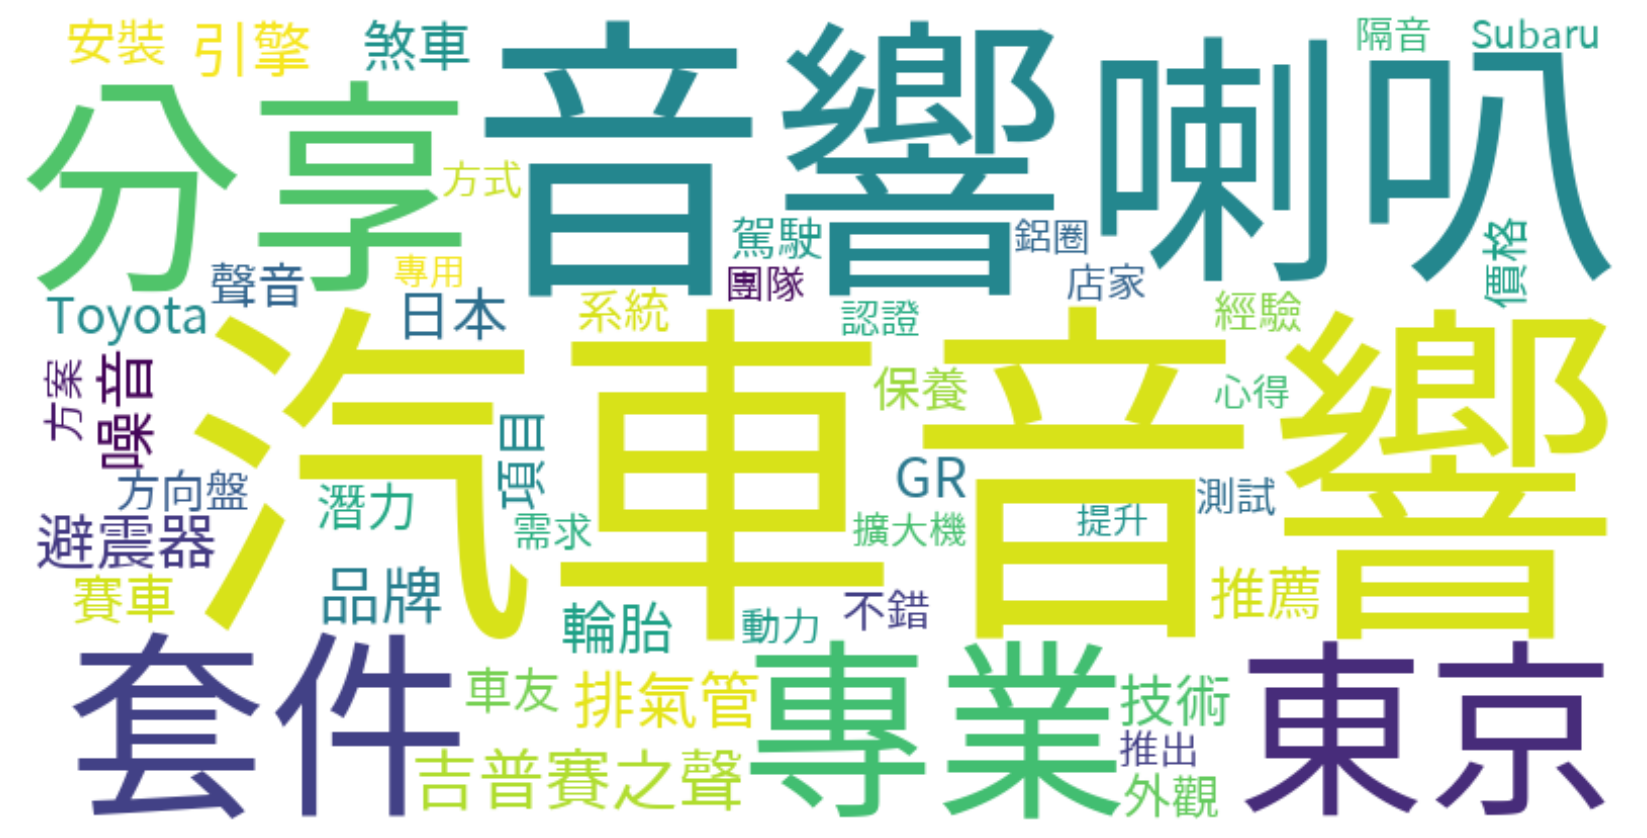

In [27]:
# 正面詞彙文字雲
wordcloud = WordCloud(
                stopwords=stopWords,
                collocations=False,
                font_path=fontPath,
                width=800,
                height = 400,
                max_words=50,
                background_color="white")

wordcloud.generate(' '.join(pos_words))

plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

文字雲顯示出在正面情緒中的熱門關鍵詞，可能與每年的東京改裝車展的影響力密切相關。<br>
詞彙如「東京」、「日本」、「Toyota」、「Subaru」、「GR」皆反映出大量與日系改裝車相關的話題出現，代表大家對日系品牌與套件熱愛。<br>
另有「音響」、「喇叭」、「吉普賽之聲」等詞，顯示音響升級仍是用戶最滿意的改裝項目之一。<br>
整體內容充滿「分享」、「專業」、「套件」等詞，代表改裝文風偏向技術與經驗交流，進一步反映社群活躍與資訊價值的提升。

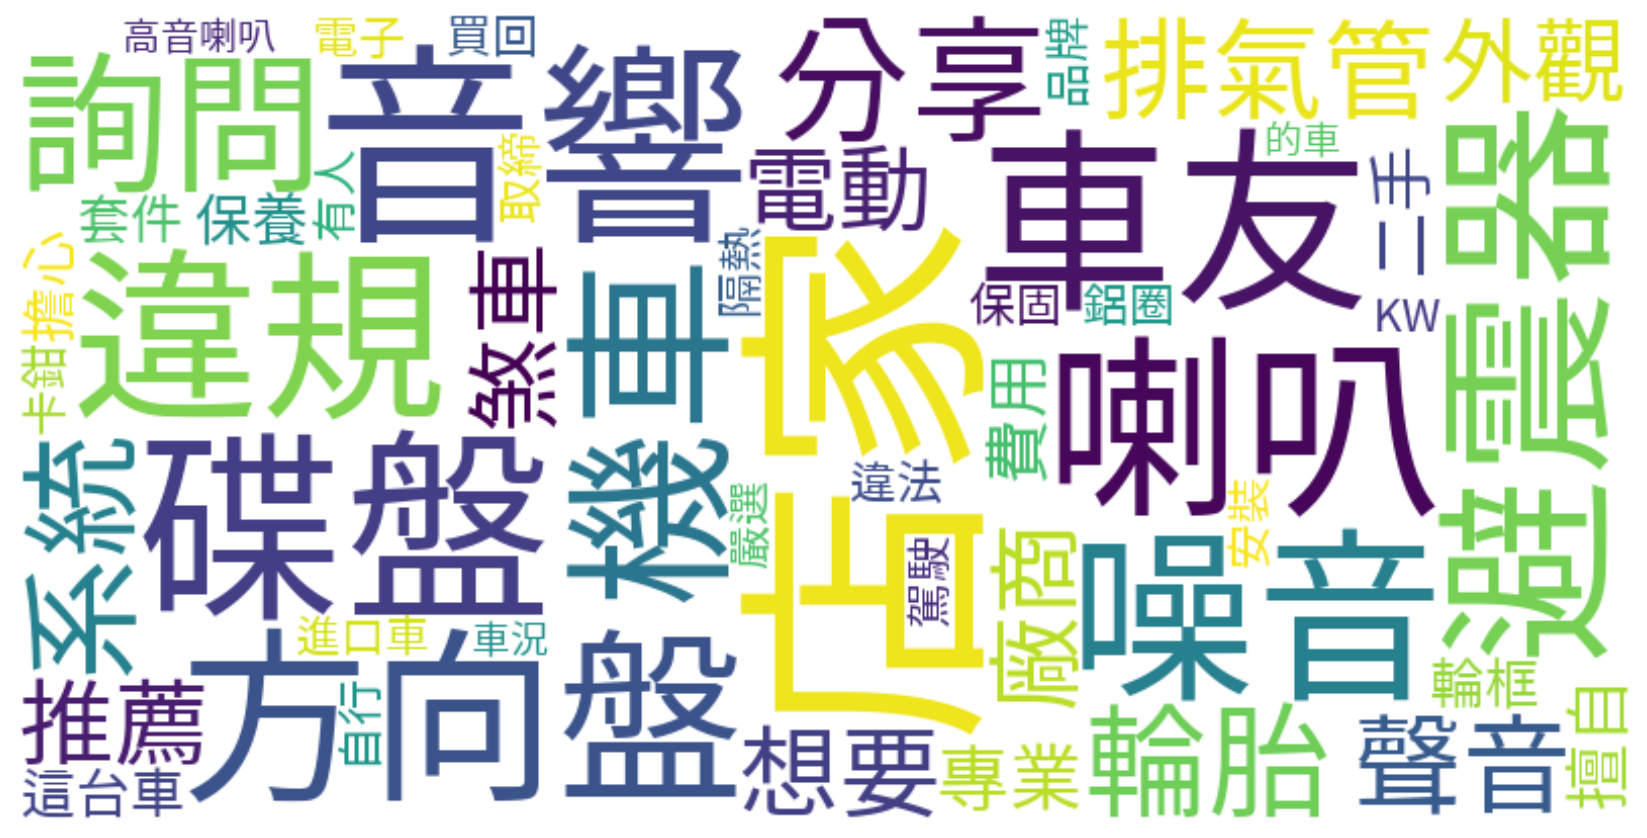

In [28]:
# 負面詞彙文字雲
wordcloud = WordCloud(
                stopwords=stopWords,
                collocations=False,
                font_path=fontPath,
                width=800,
                height = 400,
                max_words=50,
                background_color="white")

wordcloud.generate(' '.join(neg_words))

plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

從負面情緒文字雲中可以明顯觀察到，使用者表達不滿時最常針對的對象是「店家」與「廠商」，反映改裝服務品質參差不齊。<br>
此外，與操控性與安全有關的零件如「方向盤」、「碟盤」、「避震器」、「排氣管」亦是抱怨源頭，消費者可能常因不適應、異音或改裝後性能下降引發情緒反彈。<br>
同時，法規限制與二手交易問題也是引發負面情緒的重要來源，顯示台灣改裝文化中仍存在制度與法規方面的限制。

驗證文字雲中的詞彙 : 查看跟「東京」有關的正面句子，可以看到非常多跟東京改裝車展有關的話題，顯示車迷們對於車展的熱愛與重視。

In [29]:
mask = results_df['sentence'].str.contains('東京', case=False, na=False)
filtered_sentences = results_df[mask & (results_df['label'].isin(['star 4', 'star 5']))]

filtered_sentences

,sentence,label,score
933,以及名為GT86的兩部同卵雙生車種便於2011年東京改裝車展降臨於世,star 4,0.563742
6197,今日（1/11）搶在東京改裝車展正式登場之前,star 5,0.442131
10285,在2022年初的東京改裝車展舞台上,star 4,0.558825
10287,全新Fairlady Z在2022東京改裝車展上發表,star 4,0.569095
11783,左側黑色的可是剛在今年東京改裝車展發表並限量五百部的GRMN Yaris；右側披著白、黑、紅...,star 4,0.560736
11793,甫於今年東京改裝車展登場的GRMN Yaris,star 4,0.567490
15544,後來多次在東京改裝車展上大放異彩而變得相當知名,star 4,0.627174
17347,隨著即將在1月14日開幕的2022東京改裝車展接近,star 4,0.531023
17367,在今年東京改裝車展推出了全新概念車Vision Ralliart,star 4,0.471427
17435,一年一度的東京改裝車展將在本週登場,star 4,0.535009


### 4. 使用 LLM Information Extraction進行情緒分析
本階段使用 LLM Information Extraction進行情緒分析，並使用Google Colab 撰寫程式碼與呈現結果：<br>
https://colab.research.google.com/drive/11WLYky2q7DTYehRXOOnOGFSt5xpVetXF#scrollTo=jQTcjNUQ6K3f

### 5. LDA 主題模型
本階段使用 LDA 主題模型將文章進行分群，並使用Google Colab 撰寫程式碼與呈現結果：<br>
https://colab.research.google.com/drive/1Y1gkKK-iqAMjdgbUFnnCX3ain5gvKZ_y?usp=drive_link

### 6. BERT Text Clustering

In [30]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.cluster import KMeans
import jieba
import re

In [31]:
clean_data = metaData.dropna(subset=["sentence"]).drop_duplicates(subset=["sentence"]).reset_index(drop=True)
texts = clean_data["sentence"].tolist()

In [32]:
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

6.1 使用 BERTopic 建立主題模型
- 進行資料前處理，並建立embedding model
- 使用 BERTopic 進行主題模型建立
- 並採用KMeans做分群

In [33]:
jieba.set_dictionary('./dict/dict.txt.big')

# 新增 stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopwords = [line.strip() for line in f.readlines()]

# 新增自定義停用字
other_stopwords = [
    "我們", "大家", "目前", "今天", "昨天",
    "車主", "網友", "小弟", "原PO", "感謝", "拜託", "請教", "謝謝", "如題",
    "補充", "更新", "附圖", "小改", "大改", "改一點", "升級一下", "建議", "回覆", "留言",
    "連結","內容","這是","希望","選擇","當初","真的","東西","改裝","改裝車","原廠","全車",
    "算是","一台","照片","請問","有無","只能","看過","那種","這種","這台","車子","感覺","原本",
    "我會","一堆","台灣","汽車","近期","入手","備有","車型","車輛","發現","提供","這輛","則是",
    "也屬","一輛","一模一樣"
    ]

stopwords += other_stopwords

# 設定中文 embedding model
bert_sentence_model = SentenceTransformer("google-bert/bert-base-chinese")

# 將中文文章轉換為 embedding
embeddings = bert_sentence_model.encode(texts, show_progress_bar=True)

# 定義不同 clustering layer 所要使用的模型與方法（就用 default 的 HDBSCAN）
kmeans_model = KMeans(n_clusters=4)

# 定義一個適合中文的分詞函數
def tokenize_zh(text):
    words = jieba.lcut(text)
    return [w for w in words if len(w) > 1 and w.isalpha() and w not in stopwords] # 排掉一字詞、數字、標點、亂碼，讓主題詞乾淨且有語意。

# 建立一個使用 jieba 分詞的 CountVectorizer
jieba_vectorizer = CountVectorizer(tokenizer=tokenize_zh, stop_words=stopwords, analyzer='word', token_pattern=u"(?u)\\b\\w+\\b")

# 使用 BERTopic 進行主題模型建立
zh_topic_model = BERTopic(embedding_model=bert_sentence_model, vectorizer_model=jieba_vectorizer, verbose=True, top_n_words=30, hdbscan_model=kmeans_model)
topics, probs = zh_topic_model.fit_transform(texts, embeddings)

zh_topic_model.get_topic_info()

No sentence-transformers model found with name google-bert/bert-base-chinese. Creating a new one with mean pooling.


Batches:   0%|          | 0/1598 [00:00<?, ?it/s]

2025-06-15 13:41:11,531 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-06-15 13:41:25,666 - BERTopic - Dimensionality - Completed ✓
2025-06-15 13:41:25,666 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-15 13:41:25,903 - BERTopic - Cluster - Completed ✓
2025-06-15 13:41:25,913 - BERTopic - Representation - Fine-tuning topics using representation models.
Building prefix dict from /Users/paulyao/Desktop/nsysu/碩一下/SMA/SMA_2025S/final_project/dict/dict.txt.big ...
Loading model from cache /var/folders/8z/rfyy41kd2kdb5ktjc9ztld_00000gn/T/jieba.u2d5cdb311a2d65d0c7c479b91161cce9.cache
Loading model cost 0.475 seconds.
Prefix dict has been built successfully.
2025-06-15 13:41:33,856 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,0,18540,0_引擎_系統_動力_設計,"[引擎, 系統, 動力, 設計, 駕駛, 空間, 車身, 功能, 煞車, 升級, 搭配, 座...","[動力提升至後, 搭配xDrive四輪驅動系統、後輪轉向系統等利於操控的底盤配備, XLT駕..."
1,1,14367,1_分享_保養_店家_車友,"[分享, 保養, 店家, 車友, 業務, 朋友, 喜歡, 時間, 老闆, 保固, 推薦, 這...","[改音響可能會影響保固)[保養]現在買車一樣有附贈4年不限里程保固及三次免費保養, 但6萬本..."
2,2,10056,2_推出_賽車_市場_賽道,"[推出, 賽車, 市場, 賽道, 車款, 日本, 品牌, 國內, 活動, gr, 萬元, t...","[2024 Q2Suzuki Swift大改款許久未在國內推出新車的Suzuki, 這次推出..."
3,3,8157,3_時間_價格_實在_不錯,"[時間, 價格, 實在, 不錯, 值得, 確實, toyota, 肯定, 可惜, 空間, 沒...","[說實在這有點讓人感到驚艷, 我實在捏不出來, 實在美]"


將主題模型訓練結果做視覺化呈現

In [34]:
zh_topic_model.visualize_topics()

根據視覺化呈現的結果可以分為:

*   Topic 0:車輛性能相關
*   Topic 1:店家服務相關
*   Topic 2:車款車系相關
*   Topic 3:性價比相關

6.2 查看各主題的詞彙分佈

In [35]:
topic_distr, _ = zh_topic_model.approximate_distribution(texts)

100%|██████████| 52/52 [00:20<00:00,  2.52it/s]


In [36]:
# 列出主題的代表詞和其對應的權重
zh_topic_model.get_topic(2)

[('推出', 0.025815896140511666),
 ('賽車', 0.02575970498161007),
 ('市場', 0.02487315170696047),
 ('賽道', 0.022874782103592783),
 ('車款', 0.02251011489295605),
 ('日本', 0.02202365384692372),
 ('品牌', 0.021983768045799237),
 ('國內', 0.021324957850875938),
 ('活動', 0.01939159918948512),
 ('gr', 0.019263364933830462),
 ('萬元', 0.01819139059083123),
 ('toyota', 0.01742557419493577),
 ('改款', 0.016864750589189105),
 ('車系', 0.016617431290935823),
 ('發表', 0.016371493882230397),
 ('賽事', 0.015436134296639065),
 ('正式', 0.015324051574379565),
 ('版本', 0.014533527190121968),
 ('性能', 0.014407892327931203),
 ('豐田', 0.014266535641641093),
 ('噪音', 0.01380090395459683),
 ('露營車', 0.012521975493287894),
 ('rover', 0.012457664277667185),
 ('sport', 0.012273357952849132),
 ('上市', 0.011976827479655953),
 ('跑車', 0.011836122186602913),
 ('mx', 0.011809636666454947),
 ('電動車', 0.011617873927702074),
 ('認證', 0.011340277668118324),
 ('amg', 0.011265483735925341)]

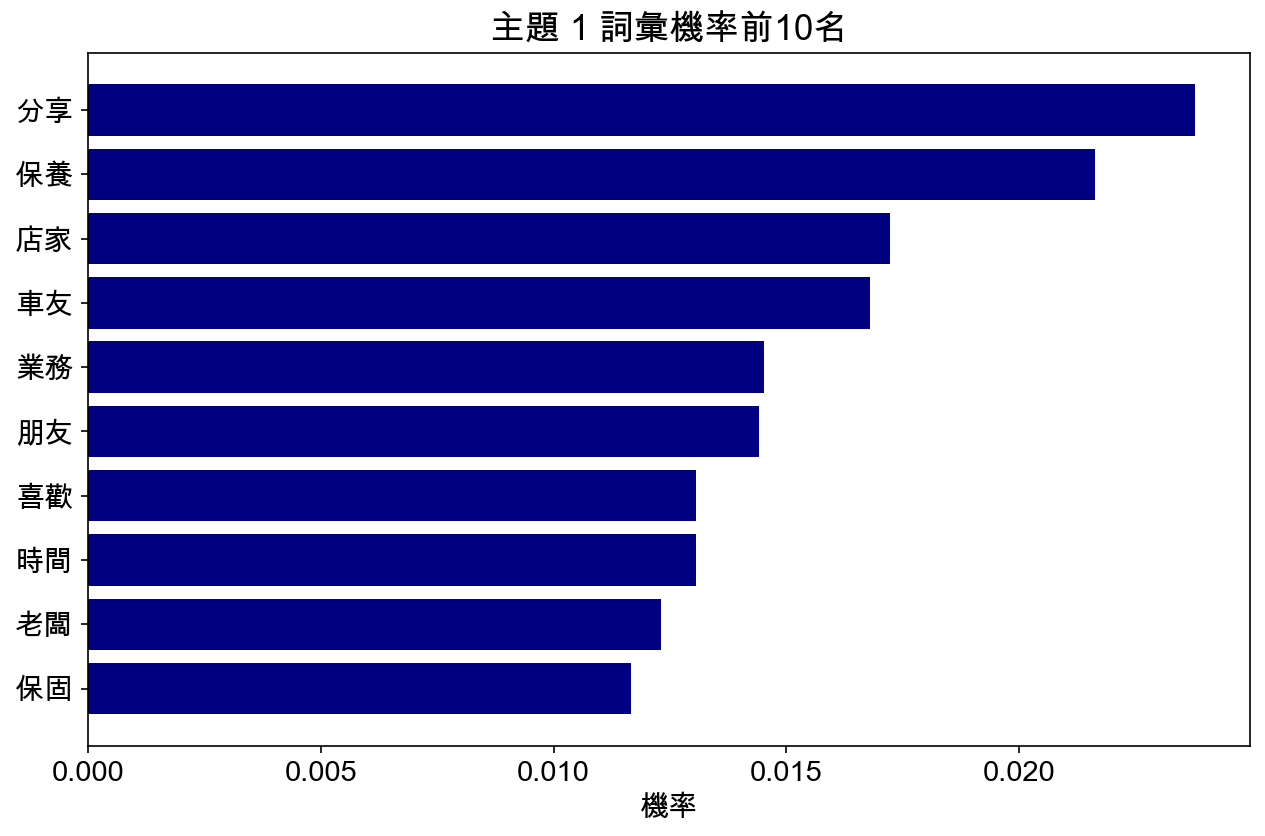

In [37]:
# 視覺化顯示主題-詞彙分佈
topic_n = 1
data = zh_topic_model.get_topic(topic_n)

# 轉換為DataFrame
topten = pd.DataFrame(data, columns=['word', 'prob'])
topten = topten[topten['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = topten.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

主題一詞彙機率前10包括了 : 分享、保養、店家、車友、業務等等詞彙，可以推論該主題可能是對於店家的服務討論較為相關。

6.3 採用KeyBERT做主題分類

In [38]:
from bertopic.representation import KeyBERTInspired
from umap import UMAP
# KeyBERT
keybert = KeyBERTInspired()


representation_model = {
    "KeyBERT": keybert,
}

建立主題模型

In [ ]:
# 建立BERTopic模型
umap_model = UMAP(n_neighbors=3, n_components=2, metric='cosine', random_state=42)
representation_topic_model = BERTopic(
  # Sub-models
  embedding_model=bert_sentence_model,
  vectorizer_model=jieba_vectorizer,
  # 設定Representation model
  representation_model=representation_model,
  # Hyperparameters
  top_n_words=30,
  hdbscan_model = KMeans(n_clusters=5), # 採用 Kmeans 分群（設為5群）
  verbose=True,
  umap_model=umap_model
)

# Train model
topics, probs = representation_topic_model.fit_transform(texts, embeddings)

2025-06-15 13:43:09,882 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-15 13:43:20,627 - BERTopic - Dimensionality - Completed ✓
2025-06-15 13:43:20,628 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-15 13:43:20,648 - BERTopic - Cluster - Completed ✓
2025-06-15 13:43:20,654 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-15 13:43:29,527 - BERTopic - Representation - Completed ✓


視覺化呈現

In [40]:
representation_topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,Representative_Docs
0,0,12667,0_分享_保養_車友_店家,"[分享, 保養, 車友, 店家, 朋友, 業務, 喜歡, 推薦, 新車, 這台車, 影片, ...","[有沒有, 方向盤, 這台車, 第一次, 避震器, 露營車, 費用, 更換, 喇叭, 車上]","[但還是要體驗一下保養的實際感受, 不知道有沒有大大有改裝可分享, 問朋友有沒有推薦的店家可..."
1,1,11010,1_引擎_推出_音響_品牌,"[引擎, 推出, 音響, 品牌, 賽車, 汽車音響, 市場, 車款, 聲音, 喇叭, 動力,...","[渦輪引擎, 保時捷, mercedes, 汽車音響, 搭載, 電動車, nissan, 渦...","[至於國內自行改裝之2.0升自然進氣引擎車輛, 標準版LBX的動力單元是以1.5升直列三缸自..."
2,2,9931,2_駕駛_動力_系統_引擎,"[駕駛, 動力, 系統, 引擎, 性能, 加速, 煞車, 升級, 馬力, 表現, 輔助, 車...","[扭力, 馬力, 變速箱, 方向盤, 避震器, 穩定性, 油門, 駕駛者, 轉速, 高速公路]","[最大動力輸出達到510hp/66.3kgm, 最大動力輸出204hp, 從引擎的輸出馬力]"
3,3,9690,3_噪音_公里_時間_公斤,"[噪音, 公里, 時間, 公斤, 整體, 車長, 鋁圈, 實在, 取締, 價格, 來到, 喜...","[停車場, 環保局, 更換, 里程, 提升, 排氣管, 性能, manhart, 公斤, 上路]","[5 年時間下來, 油耗大概是5.X/100公里, 而極速也提升了17公里]"
4,4,7822,4_空間_螢幕_設計_系統,"[空間, 螢幕, 設計, 系統, 座椅, 調整, 功能, 方向盤, 安裝, 配置, 中央, ...","[方向盤, 避震器, 變速箱, 中控台, 座椅, 尾翼, 碳纖維, 按鍵, 設定, 尾燈]","[座椅造型與乘坐感受維持相同設定, 置物空間卡榫這邊設計了一些收納空間, 只留下中央的大型觸..."


In [41]:
representation_topic_model.visualize_topics()

根據視覺化呈現的結果可以分為:

*   Topic 0:店家服務相關
*   Topic 1:音響播放裝置相關
*   Topic 2:車輛性能相關
*   Topic 3:車輛環保相關
*   Topic 4:車內空間相關

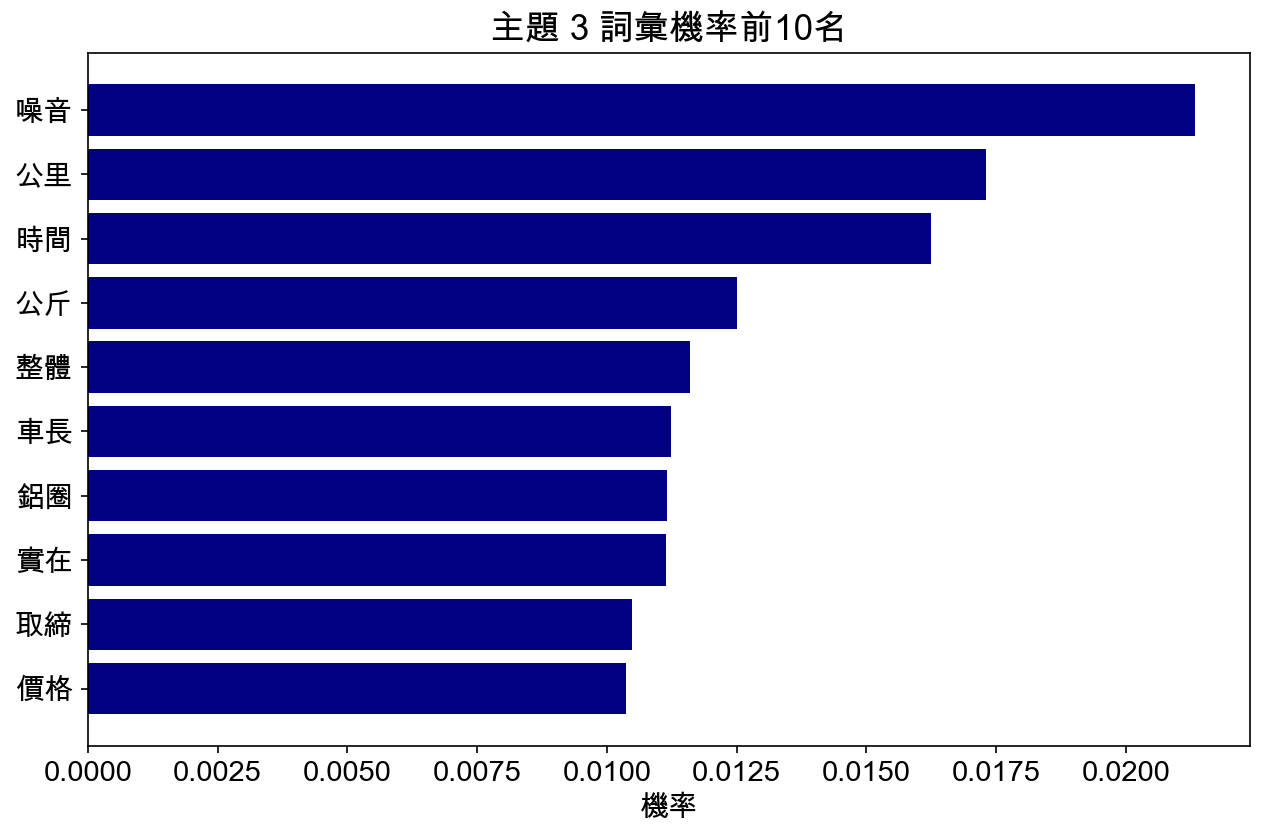

In [42]:
# 視覺化顯示主題-詞彙分佈
topic_n = 3
data = representation_topic_model.get_topic(topic_n)

# 轉換為DataFrame
topten = pd.DataFrame(data, columns=['word', 'prob'])
topten = topten[topten['word'] != ' ']

# 根據prob排序並選出前10名
top_10 = topten.sort_values('prob', ascending=False).head(10)

# 畫出長條圖
plt.figure(figsize=(10,6))
plt.barh(top_10['word'], top_10['prob'], color='navy')
plt.xlabel('機率')
plt.title(f'主題 {topic_n} 詞彙機率前10名')
plt.gca().invert_yaxis()
plt.show()

主題三詞彙機率前10包括了 : 噪音、公里、時間、公斤、取締等等詞彙，可以推論該主題可能是對於車輛在環保上，包括油耗、聲音等等在環保法規上的一些相關討論。

### 7. 詞彙關係圖

In [45]:
import nltk
from nltk.util import ngrams

In [46]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]

    return seg_list

In [47]:
car_bigram = metaData.copy()

car_bigram["word"] = car_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
car_bigram = car_bigram.explode('word')

car_bigram.head(3)

,system_id,artUrl,artDate,artTitle,artContent,sentence,word
0,1,https://www.mobile01.com/topicdetail.php?f=264...,2022-12-04,"7代 Camry hybrid JBL音響,前門板共振聲請益",近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...,近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...,Camry hybrid
0,1,https://www.mobile01.com/topicdetail.php?f=264...,2022-12-04,"7代 Camry hybrid JBL音響,前門板共振聲請益",近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...,近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...,hybrid Q版
0,1,https://www.mobile01.com/topicdetail.php?f=264...,2022-12-04,"7代 Camry hybrid JBL音響,前門板共振聲請益",近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...,近期入手一台7代Camry hybrid Q版(備有JBL音響的等級)聆聽音樂時發現只要音量...,Q版 JBL


In [ ]:
from nltk.probability import FreqDist

# 1. 過濾掉字串 "nan"
mask = car_bigram['word'] != 'nan'
filtered_words = car_bigram.loc[mask, 'word']

# 2. 將每個 bigram 字串拆成 tuple
filtered_words = filtered_words[filtered_words.apply(lambda x: isinstance(x, str))] # 先將非字串的值排除
bigram_tuples = filtered_words.apply(lambda x: tuple(x.split(' ')))

# 3. 用 FreqDist 計算各 bigram 出現的次數
fdist = FreqDist(bigram_tuples)

# 4. 列出最常出現的 5 組 bigram
print(fdist.most_common(5))

[(('吉普賽', '之聲'), 107), (('GR', 'Yaris'), 102), (('Range', 'Rover'), 97), (('自然', '進氣'), 95), (('Town', 'Ace'), 82)]


In [55]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in fdist.most_common(50)}

In [56]:
import networkx as nx
import matplotlib.pyplot as plt
# Create network plot
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率

# 取得調整edge權重
weights = [w[2]['weight']*0.03 for w in  G.edges(data=True)]

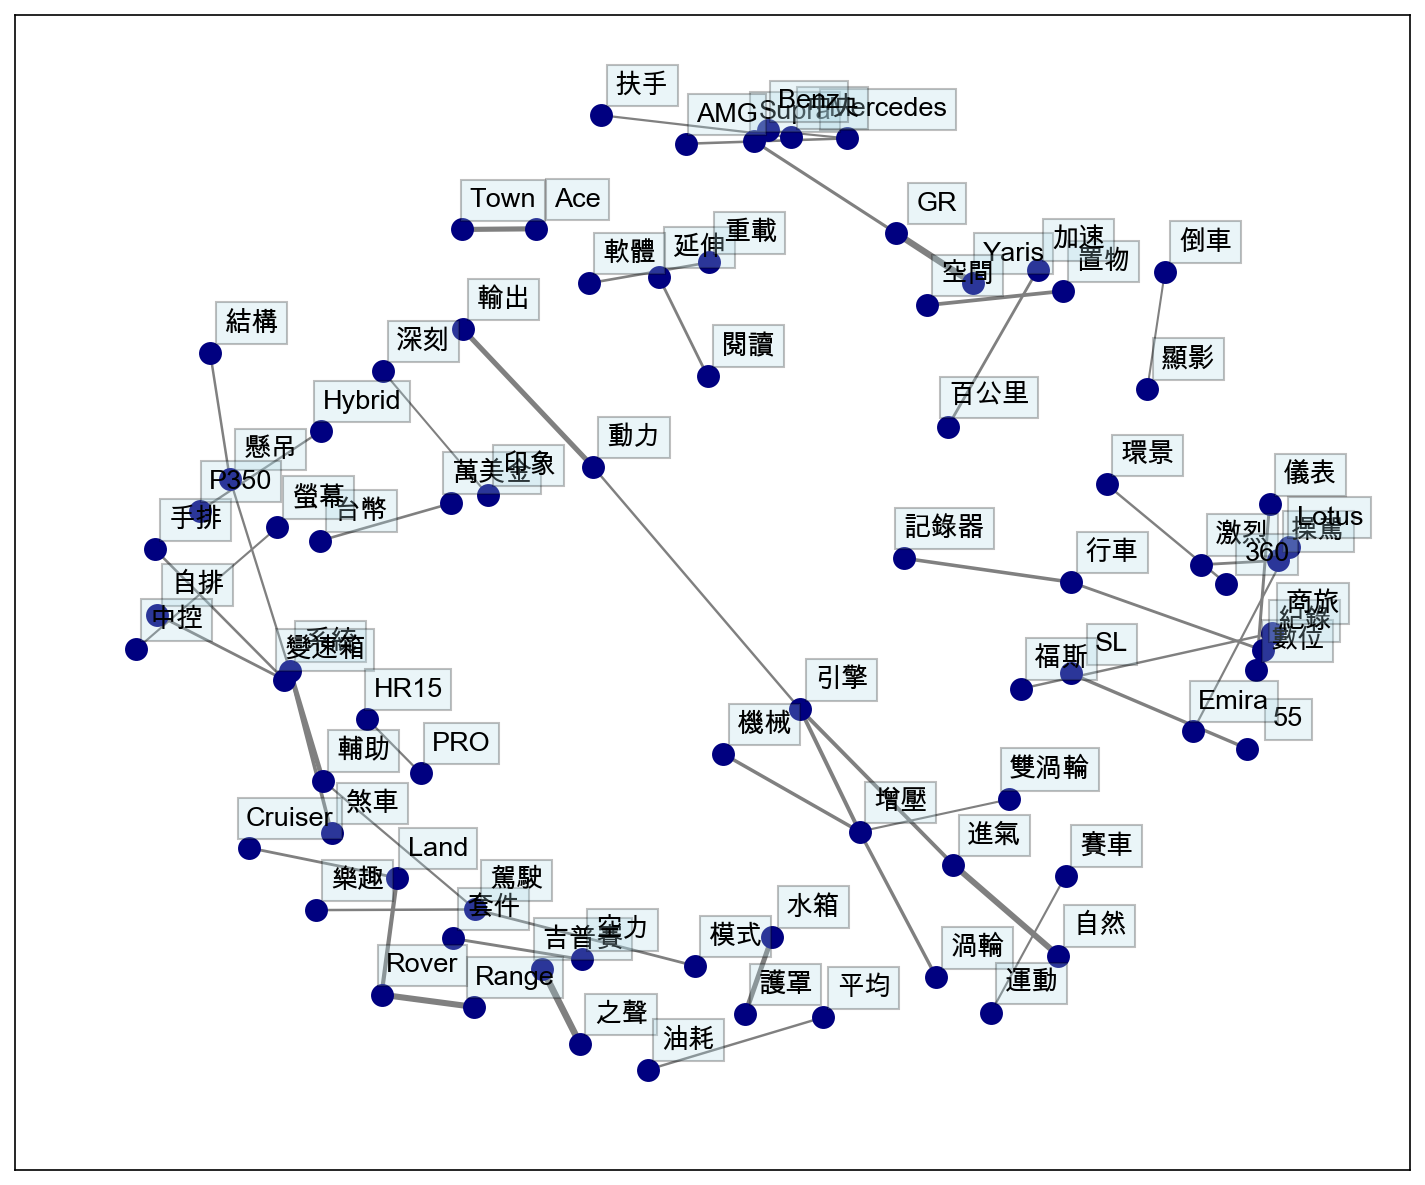

In [60]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='navy',
                 node_size=100,
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='lightblue', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

從此共線圖中，可以觀察到幾個主要關鍵詞：

1. 動力與引擎為中心議題

    “輸出”、“動力”、“引擎”、“增壓”、“渦輪增壓” 等詞組緊密相連，顯示改裝者關注的是馬力輸出與加速性能。


2. 舒適度與操控平衡

    “懸吊”、“系統”、“輔助”、“模式” 等詞成為一組，代表車主在追求動力之外，也同樣關注改裝後的行駛穩定性、調校、電子模式的優化。

### 8. 社群網路分析
本階段針對Mobile01汽車改裝話題之社群討論進行社群網路分析，並使用Google Colab 撰寫程式碼與呈現結果：<br>
https://colab.research.google.com/drive/1fvSzLmA98Rdy1pGAkoq6FWTM9ssUJyXm?usp=drive_link

### E. 結論
1. <b>資料前處理</b>：<br>
完成汽車改裝相關文章的清理與斷詞作業後，可以透過文字雲視覺化分析發現論壇討論焦點集中於「駕駛體驗」、「性能提升」與「內裝功能」，顯示用戶關注改裝對實際使用與舒適性的影響，整體語調也蠻理性且偏正向，顯示該資料集具備良好的分析基礎。

2. <b>Lexicon-based 情緒分析</b>：<br>
透過詞彙式的情緒分析，繪製出正負情緒詞彙的時序變化，我們發現論壇多數文章整體偏向正向情緒，且在特定時段有明顯正向情緒高峰，顯示用戶對汽車改裝經驗普遍持肯定態度，也可能與特定車款發佈或改裝成果分享大會有關（例如：東京改裝車展、台北國際改裝車展SGT等）。

3. <b>BERT sentiment classification</b>：<br>
(1) 經由 BERT embedding model 進行情緒分析，可以發現所產出的情緒分數大多集中在中性至微弱正向區間，顯示用戶對改裝相關討論的情緒表現不強烈、較為溫和。情緒分布也沒有呈現極端的現象，信心程度偏向中間，再次反映出該論壇的整體討論偏向正面理性。<br>
(2) 透過正負面情緒長條圖與文字雲，可以發現正面的情緒大多出現了一些消費者反映較好的改裝品，如：汽車音響、喇叭套件等，我們原本以為大家偏好改裝的部品不太會出現音響喇叭，因此這部分的結果令我們相當意外。而負面情緒也出現像是違規或噪音等社會的現象，顯示出社群上大家接受改裝的同時，也會去遵守法規並討論違法改裝相關的議題，以遏止不良風氣對改裝圈的影響。

4. <b>LLM Information Extraction情緒分析</b>：<br>
使用LLM Information Extraction進行汽車改裝討論情緒分析，大多數留言屬於中性語氣，多為客觀描述或試駕、分享改裝心得，例如「只要試過幾次熟悉流程後…」、「DMS除了手勢調整空調溫度、辨識駕駛者身分…」。負向評論多見於使用者對實際駕駛體驗或產品改裝店家的不滿，例如「害我再也不敢用 ECO 開車」或「警示文：事情是這樣的今天要來公布無良商家的故事…」帶有明顯的抱怨或警告意味。透過LLM Information Extraction情緒分析，店家可更有效收集並回應買家痛點，汽車改裝社群交流也更能提升貼文品質與討論價值。<br>

5. <b>LDA 主題模型</b>：<br>
(1) 在主題一中，可以發現討論重點包括車輛的外觀設計、內裝配備、動力系統與功能升級，這反映了消費者的偏好，並且可以藉此來發展出市場的策略，藉此提升消費者的滿意度。 <br>
(2) 在主題二中，可以發現討論的重點包括了一些車主的日常保養、維修與實際使用經驗，根據這些討論對於一些維修店家、車廠可以作為一個參考的反饋，使店家可以了解消費者的滿意度以及關注的焦點，藉此發展更好的服務滿足消費者。 <br>
(3) 在主題三中，可以發先討論的重點聚焦於車輛的性能表現與駕駛操控經驗，可以了解到消費者在不同的道路情境下所需要的操控體驗，例如在山道與越野間就有非常大的區別，同時，根據這些資料，店家可以根據不同消費者提供不同的改裝建議以及更客製化的內容來滿足消費者。 <br>
(4) 在主題四中，可以發現討論的重點聚焦於汽車音響與影音升級改裝體驗，這個主題打破了對於汽車改裝既有的思想，一般情況下大眾對於汽車改裝的印象即是大多針對外觀、性能做改裝，然而，在經過研究過後發現，影音設備也成為了近代車輛改裝的趨勢之一，透過這樣的發現，店家可以更深入去開發車用影音設備的相關市場以搶占先機，並提供更優良的影音設備改裝服務給消費者。 <br>

6. <b>BERTopic 主題模型</b>：<br>
(1) 採用了KeyBERT的方式使得分類的主題更有聚焦性與解釋性，並且在分成4群及5群上也可以發現採用KeyBERT並分類成4群，對於每一群有更好得解釋性。 <br>
(2) 根據keyBERT的分類結果可以得出5個主題。 <br>
(3) 在主題0中，發現討論聚焦於店家服務相關，根據討論的內容，可以了解優質的店家有哪些，是那些原因促使這些的店家評論較高，並可以當作參考的依據使其他店家可以效仿，提供更優質的服務給消費者。 <br>
(4) 在主題1中，發現影音設備成為了車輛改裝的趨勢之一，可以提讓店家發現到與傳統對於改裝的印象有所不同，改裝不僅僅侷限於性能、外觀上，近年來甚至對於影音的需求也相當大，店家可以根據這樣的發現去發展影音領域的相關改裝服務來滿足消費者。 <br>
(5) 在主題2中，發現討論主要聚焦於車輛性能改裝相關，可以提供給店家瞭接最新的改裝趨勢，藉此提供給消費者最新效果表現上最佳的產品來滿足消費者的需求。 <br>
(6) 在主題3中，發現討論主要著重在噪音、油耗取締等等內容，可以發現消費者對於車輛的環保性上以及是否符合環保法規的重視，根據這些發現，店家、車廠也可以發展燃燒效率更好、低空污、低噪音汙染等等的相關產品，甚至去進一步改良現有產品以滿足消費者的喜好。 <br>
(7) 在主題4中，發現討論主要著重在車內空間上，這樣的發現可以使車廠在進行車款的設計、改良時更有效的規劃車內空間，滿足使用者的需求。 <br>
* <b>BERTopic V.S LDA</b> <br> 
LDA與BERTopic在同樣分成4群的狀況下，可以看到BERTopic所分出來的主要為3大類，以及最後一個主題較不明顯的性價比相關的內容，但在性價比內容中包含了許多沒什麼意義的代表字，像是可惜、肯定等等詞彙，可以發現BERTopic的主題分群上涵蓋範圍較廣，主題上可能相對較不明確。<br>
而相反的，LDA對於每個主題都有很明確的可解釋性，在四個主題中根據常出現的一些代表字，像是主題一的系統、動力，還有主題二的保養、店家等等，可以很明確的知道，也能夠聚焦在單一領域的討論內容中。<br>

7. <b>詞彙關係圖</b>：<br>
透過詞彙關係圖，可見不同品牌於使用者心中各有核心訴求，像是Toyota 86 強調賽道性能、賽車化的調校，而「加速」、「百公里」、「油耗」則反映使用者在選購／改裝時同時關注性能提升與燃油效率平衡。建議廠商在行銷與產品開發時，可依此不同主題制定差異化策略，提高目標族群的認同感與購買意願。<br>

8. <b>社群網路分析</b>：<br>
根據我們繪製出的社群網路圖，可以找出板上參與較為熱烈與扮演關鍵角色的用戶。然而，在此主題中，網路圖仍呈現較為鬆散的結構，用戶之間以單向提供意見、個別主題進行互動為主，較缺乏跨主題或跨文章的交流，難以形成穩定的社群網路。我們推測可能是因為以下幾個原因： <br>
(1) 改裝主題屬於高度個人化的經驗分享，各車主的需求與條件差異較大，導致互動多為個別詢問與回應，較難形成長期穩定的對話關係。 <br>
(2) 改裝討論大多偏向於解決問題導向，互動目的為取得資訊或技術建議，而非建立人際關係，導致網路關係相對分散。 <br>
(3) Mobile01討論風格偏向功能性交流，討論主題具體、集中，較少產生跨主題的人際互動。 <br>